In [1]:

from appyter import magic
magic.init(lambda _ = globals: _())

In [2]:
%%appyter markdown
# Gene Set Library Synopsis Appyter
This appyter is designed to perform basic statistics, analysis, and visualizations on a Gene Matrix Transpose (.GMT) file. This will allow bioinformatics researchers to analyze relationships between many different gene sets from several gene set libraries.
 To create your own GMT file, please see Enrichr. Enrichr, hosted by the Ma'ayan Laboratory at Mt. Sinai Icahn School of Medicine, is a collection of geneset libraries. 

# Gene Set Library Synopsis Appyter
This appyter is designed to perform basic statistics, analysis, and visualizations on a Gene Matrix Transpose (.GMT) file. This will allow bioinformatics researchers to analyze relationships between many different gene sets from several gene set libraries.
 To create your own GMT file, please see Enrichr. Enrichr, hosted by the Ma'ayan Laboratory at Mt. Sinai Icahn School of Medicine, is a collection of geneset libraries. 

In [3]:
import numpy as np 
import pandas as pd
import itertools 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pathlib
import scanpy as sc
from IPython.display import display, FileLink, HTML, Markdown, IFrame
import anndata
import networkx as nx
from statsmodels.stats import multitest as mlt
from sklearn.feature_extraction.text import TfidfVectorizer
from maayanlab_bioinformatics.enrichment import crisp
from collections import OrderedDict
from bokeh.palettes import Category20, Turbo256
import statistics as stat
from bokeh.io import output_notebook
from bokeh.models import HoverTool, ColumnDataSource
from bokeh.plotting import figure, show, save, output_file
from bokeh.models.tickers import FixedTicker
import plotly.graph_objs as go
from plotly.offline import iplot
from scipy.cluster.hierarchy import linkage, dendrogram
import seaborn as sns
import os
from pyvis.network import Network
output_notebook()

Loading BokehJS ...

In [4]:
%%appyter hide_code


{% do SectionField(name='GMTSubmission', title='1. Submit a GMT file', subtitle = 'Sumbit a GMT (Gene Matrix Transpose file) for analysis.', img = 'data-upload-icon.png') %}
{% do SectionField(name = 'GMT Descriptive Statistics', title = '2. Descriptive Statistics', subtitle = 'Generate descriptive statistics for the gene sets.', img = 'bar-icon.png') %}
{% do SectionField(name = 'Pairwise Similarity Table', title = '3. Pairwise Intersection Table', subtitle = 'In this table, the value in row A, column B, is the size of the intersection of A and B. For a small GMT file,  A ball and stick visualization will also be generated showing significant intersections.', img = 'set-similarity.png') %}
{% do SectionField(name = 'Metrics', title = '4. Pairwise Metrics', subtitle = 'Select pairwise metrics to measure pairwise similarities between gene sets. NOTE: For Hierarchical Clustering, you must select yes for one of the options.', img = 'cluster-icon.png') %}
{% do SectionField (name = 'UMAP_visualization', title = '5. Scatterplot Visualization', subtitle= 'Visualize relative gene set similarities on an interactive scatterplot.', img = 'scatter-icon.png') %}
{% do SectionField(name = 'HC', title = '6. Hierarchical Clustering', subtitle = 'Cluster gene sets and visualize them using a Dendrogram and Heatmap.', img = 'analysis.png') %}




In [5]:
%%appyter code_exec

{% set gs =
            FileField(
                name='gs',
                label='Gene Set Files',
                default= 'static/combined.gmt',
                example={
                    'example.gmt': url_for('static', filename = 'combined.gmt')
                },
    
section = 'GMTSubmission',) %}

{% set file = gs %}
file = {{ file }}



int_tbl = {{BoolField(name = 'SimilarityTbl', label = 'Intersection Size Table', default = 'true', description = 'In this table, the value in row A, column B, is the size of the intersection of A and B. If you would like to get a list of genes from a specific intersection of two library terms, please see the Intersection Search Section. Select \'Yes\' if you would like to generate a Intersection Size Table. Otherwise, select \'No\'', section = 'Pairwise Similarity Table') }}
jaccard = {{BoolField(name = 'Jaccard', label = 'Jaccard Metric', default = 'true', description = '', section = 'Metrics') }}
otoc = {{BoolField(name = 'Otoc', label = 'Otsuka-Ochiai Metric ', default = 'true', description = '', section = 'Metrics') }}


umap = {{ BoolField(name = 'umap', label = 'ScatterPlot Visualization', default = 'true', description = 'Select \'Yes\' if you would like to generate a Scatter Plot. Otherwise, select \'No\'', section = 'UMAP_visualization')}}
desc_stat = {{ BoolField(name = 'desc_stat', label = 'Descriptive Statistics', default = 'true', description = 'Select \'Yes\' if you would like to generate Descriptive Statistics. Otherwise, select \'No\'', section = 'GMT Descriptive Statistics')}}

umap_num_neighbors = {{ IntField(name = 'nneighbors', label = 'Number of Neighbors', default = 5, min = 1, max = 30, description = 'We recommend you leave the default number of neighbors. If the visualization does not cluster, rerun the appyter and change the number slightly.', section = 'UMAP_visualization')}}
umap_maxdf = {{ ChoiceField(name = 'max_df', label = 'Max df setting', choices = {'0.5': '0.5', '0.75': '.75', '0.9': '.9', '1.0': '1'}, default = '0.5',  description = 'We recommend you leave the default. If the visualization does not cluster, rerun the appyter and change the value.', section = 'UMAP_visualization')}}
umap_mindf = {{ ChoiceField(name = 'min_df', label = 'Min df setting', choices = {'0.1' : '0.1', '0.25' : '0.25', '0.5': '0.5' }, default = '0.25', description = 'We recommend you leave the default. If the visualization does not cluster, rerun the appyter and change the value.', section = 'UMAP_visualization')}}
linkage_choice = "{{ ChoiceField(name = 'Linkage Method', label = 'Linkage Method to Use in Hierarchical Clustering', choices = ['average', 'single', 'complete'], default = 'complete',  description = 'A Linkage method describes how to define distances between clusters. Single performs well on non-globular data. Complete and Average perform well on globular data', section = 'HC') }}"


```python
file = 'static/combined.gmt'
int_tbl = True
jaccard = True
otoc = True
umap = True
desc_stat = True
umap_num_neighbors = 5
umap_maxdf = 0.5
umap_mindf = 0.25
linkage_choice = "complete"
```

In [6]:
if file == '' :
    raise Exception('Please upload a GMT File!')
if file.split('.')[1] != 'gmt':
    raise Exception('Invalid File, Please upload a GMT File')

In [7]:
def series_to_list(gene_list):
    ##helper function to convert a gene pd.series to a gene list
    ret_list = []
    for genes in gene_list:
        if type(genes) is str:
            ret_list.append(genes)
        else: ##pd series case
            genes = genes.tolist()        
            ret_list.append(' '.join(genes))
    return ret_list

def load_set(file):
    ''' Load a set of files into pairs of labeled sets
    '''
    lst= []
    path = pathlib.Path(file)
    with open(path) as f:
        lines = f.readlines()
        for line in lines:
            parsed_line = line.split('\t')
            term, library, genes = parsed_line[0], parsed_line[1], parsed_line[2:]
            if genes[-1][:-2] == '\n':
                genes[-1] = genes[-1][:-2] ##trim off newline regex '\n'
            lst.append((term,  library, ' '.join(genes)))
    zip_lst = [list(i) for i in zip(*lst)]
    term, library, genes = zip_lst[0], zip_lst[1], zip_lst[2]
    genes = series_to_list(genes)

    df = pd.DataFrame({'Genes': genes, 'Library': library}, index = term)
    df = df[~df.index.duplicated(keep = 'first')]
    return df              

In [8]:
try:
    df = load_set(file)
except: 
    print('GMT is not in the proper format!')
if df.shape[0] < umap_num_neighbors:
    umap_num_neighbors = int(np.ceil(df.shape[0]/2)) ##arbitrary right now. May want to change based on parameter settings
    print('Number of Neighbors parameter in scatterplot is too large for the submitted dataset. Resetting number of neighbors to '+ str(umap_num_neighbors)+'')


In [9]:
%%html
 <style> .text_cell_render .h1 { font-size: 200%; }</style>

In [10]:
def calculate_FET(set1, set2, background = 20000):
    ##inputs: set1, set2 - python sets
    ##output: p-value of the fisher exact test
    res = crisp.fisher_overlap(set1, set2, n_background_entities= background, preserve_overlap=True)
    if res == None:
        return 10 ##arbitrary insignificant pvalue
    else:
        return res.pvalue

In [11]:
def calculate_OTOC(set1, set2):
### calculates the Otsuka-Ochiai coefficient, returns 0 if the empty set is passed
    try:
        set1_size = len(set1)
        set2_size = len(set2)
        K = len(set1 & set2)/np.sqrt(set1_size*set2_size)
        return K
    except: 
        return 0 ##empty set 

In [12]:
def get_itertuple(str1, str2):
    ##given two strings (which should be terms in the given gmt), get the tuple back that will index into the pair_df
    ##itertools.combos gives tuples that are alphabetically ordered for strings.
    return (str1, str2) if str1 < str2 else (str2, str1) 

def clean_name(dir_name):
    dir_name = dir_name.replace(' ', '_')
    dir_name = dir_name.replace('/', '_')
    dir_name = dir_name.replace(':', '_')
    dir_name = dir_name.replace('(', '_')
    dir_name = dir_name.replace(')', '_')
    dir_name = dir_name.replace('<', '_')
    dir_name = dir_name.replace('>', '_')
    dir_name = dir_name.strip()
    if len(dir_name) >  60:
        dir_name = dir_name[0:30] + '...' + dir_name[-30:]
    return dir_name


def make_dirs(str1):
    if not os.path.exists(f'Intersection_Sets/{str1}'):
        os.mkdir(f"Intersection_Sets/{str1}")
    return
        
def save_set(str1, str2, intersection_set):
    term1, term2 = clean_name(str1), clean_name(str2)
    term1, term2 = get_itertuple(term1, term2)
    make_dirs(term1)
    ##str1, str2 are terms to save set in system by. geneset is set of the intersection set to save
    series = pd.Series(list(intersection_set))
    full_name = os.path.join(r'Intersection_Sets', term1, term2) 
    try:
        series.to_csv(full_name+'.csv', index = False)
    except: 
        pass
    return

In [13]:
def BH_test(pair_df, alpha = .05):
    #benjamini hochberg multiple test correction
    #input: pair_df: pairwise dataframe as described above
    #input: alpha: a priori significance level 
    #output: an extended pair_df dataframe with two new columns, 'BH_sig'- a boolean column where True implies significant overlap and 'BH_corrected_pval' 
    ##- a  pvalue adjust for multiple hypothesis testing
    pvals = pair_df['FET_pval'].tolist()
    sig, corrected_pval = mlt.fdrcorrection(pvals, alpha, method = 'indep')
    pair_df['BH_sig'] = sig
    pair_df['BH_corrected_pval'] = corrected_pval
    pair_df['BH_corrected_pval'] = pair_df['BH_corrected_pval'].replace(0, pair_df.loc[pair_df['BH_corrected_pval'] != 0, 'BH_corrected_pval'].min())
    pair_df['-log10_BH_pval'] = -np.log10(pair_df['BH_corrected_pval'])
#     pair_df['-log10_BH_pval']= pair_df['-log10_BH_pval'].replace(np.inf, pair_df.loc[pair_df['-log10_BH_pval'] != np.inf, '-log10_BH_pval'].max())
    return pair_df
    

In [14]:
def series_to_str(el):
    if type(el) == str:
        return el
    else:
        return ' '.join(el.tolist())

def generate_pairs_df(df, background = 20000):
    ##inputs: df - pandas dataframe that is the result of GMT_to_df transformation
    ##output: pair_df - pandas dataframe whose rows are indexed by a tuple/ pair of terms in the set of Gene set 
    # #terms and columns represent calculated set properties between the two sets

    
    os.makedirs("Intersection_Sets", exist_ok = True)
    intersection = []
    in_A_not_B = []
    in_B_not_A = []
    union = []
    jaccard = []
    FET_pval = []

    to_set = lambda el: set(series_to_str(el).split(' '))
    space_counter = lambda str1: str1.count(" ") +1
    terms = list(df.index.values)
    int_df = pd.DataFrame(index = terms, columns = terms)
    jac_df = pd.DataFrame(index = terms, columns = terms)
    otoc_df = pd.DataFrame(index = terms, columns = terms)
    pairwise_perms = list(itertools.combinations(terms,2))
    for term1,term2 in pairwise_perms:
        setA, setB = df.loc[term1]['Genes'], df.loc[term2]['Genes']
        set1, set2 = to_set(setA), to_set(setB)
        intersect = set1 & set2
        save_set(term1, term2, intersect)


        union_set = set1 | set2
        intersection.append(' '.join(list(intersect)))
        in_A_not_B.append(' '.join(list(set1 -set2)))
        in_B_not_A.append(' '.join(list(set2 - set1)))
        union.append(' '.join(list(union_set)))
        pval = calculate_FET(set1, set2)
        FET_pval.append(pval)

        int_size = len(intersect)
        uni_size = len(union_set)
        jaccard = "{:.2f}".format(int_size/uni_size)
        
        term1_c, term2_c = get_itertuple(clean_name(term1), clean_name(term2)) ##clean and reorder the terms to the appropriate directory mapping
        
        jac_df.loc[term1, term2] = jaccard
        jac_df.loc[term2, term1] = jaccard
        
        otoc = "{:.2f}".format(calculate_OTOC(set1, set2))
        otoc_df.loc[term1, term2] = otoc
        otoc_df.loc[term2, term1] = otoc
        
        
        
        if int_size != 0:
            int_df.loc[term1, term2] = f'<div class = "df-wrap" style = "border: 1px solid; font-weight:bold; background-color: Floralwhite; 2px; height: 1.5em; width: 21px; border-radius: 4px; color: black; float: right; text-align: center"><a style = "text-decoration: none; color: black;" href = "Intersection_Sets/{term1_c}/{term2_c}.csv">{int_size}</a></div>'
            int_df.loc[term2,term1] =  f'<div class = "df-wrap" style = "border: 1px solid; font-weight:bold; background-color: Floralwhite;  height: 1.5em; width: 21px; border-radius: 4px; color: black; float: right; text-align: center"><a style = "text-decoration: none; color: black;" href = "Intersection_Sets/{term1_c}/{term2_c}.csv">{int_size}</a></div>'
        else:
            int_df.loc[term1,term2] = 0
            int_df.loc[term2,term1] = 0



    pair_df = pd.DataFrame({'Intersection' : intersection, 'A-B' : in_A_not_B, 'B-A' : in_B_not_A, 'Union': union, 'FET_pval': FET_pval}, index = pairwise_perms)
    pair_df['intersect_size'] = pair_df['Intersection'].map(space_counter)
    pair_df['union_size'] = pair_df['Union'].map(space_counter)
    pair_df['Jaccard'] = pair_df['intersect_size'] / pair_df['union_size']
    pair_df = BH_test(pair_df)

    
    np.fill_diagonal(int_df.values, 0)
    np.fill_diagonal(jac_df.values, str(0))
    np.fill_diagonal(otoc_df.values, str(0))
    
    

    return pair_df, int_df, jac_df, otoc_df




In [15]:
pair_df, int_df, jac_df, otoc_df = generate_pairs_df(df) ##this may take a minute to complete!

In [16]:
%%appyter markdown 
## 1. Descriptive Statistics

## 1. Descriptive Statistics

In [17]:
def basic_stats(df, pair_df):
    geneset_lst = df['Genes'].to_list()
    geneset_lst = [l.split(' ') for l in geneset_lst]
    gene_count = {}
    sig_term_count = {}
    geneset_size = []
    num_lib = len(df['Library'].unique()) ## for sizing the x, y axis
    num_terms = df.shape[0]

    for gene_set in geneset_lst:
        geneset_size.append(len(gene_set))
        for gene in gene_set:
            if gene in gene_count:
                gene_count[gene] +=1
            else:
                gene_count[gene] =1
                
    sig_df = pair_df[pair_df['BH_sig'] == True]
    sig_pairs = list(sig_df.index.values)
    sig_pair_lst = list(itertools.chain(*sig_pairs))
    for term in sig_pair_lst:
        if term in sig_term_count:
            sig_term_count[term] +=1
        else:
            sig_term_count[term] = 1
    sig_term_lst = list(sig_term_count.values())
    
    num_genes = len(gene_count)
    num_genesets = len(geneset_size)
    
    lst_stats = lambda lst, stat_name: {'Statistic': stat_name, 'Average': stat.mean(lst), 'Median': stat.median(lst), 'Standard Deviation': stat.stdev(lst), 'Maximum': max(lst), 'Minimum': min(lst)}
    gene_occurence_lst = list(gene_count.values())
    
    
    gene_occ_stats = lst_stats (gene_occurence_lst, 'Gene Occurence')
    sig_terms_stats = lst_stats(sig_term_lst, 'Significant Pairwise Intersections')
    geneset_stats = lst_stats(geneset_size, 'Gene Set Size')
    
    
    data = [gene_occ_stats, geneset_stats, sig_terms_stats]
    stat_df = pd.DataFrame.from_dict(data)
    stat_df.set_index('Statistic')
    stat_df.round(2)
    
    return stat_df, gene_count, sig_term_count, geneset_size, num_genes, num_genesets, num_lib

In [18]:
if desc_stat:
    stat_df, gene_count, sig_term_count, geneset_size, num_genes, num_genesets, num_lib = basic_stats(df, pair_df)
    stat_df = stat_df.round(3)

    
    html_string= f'''<div><br><br><strong style = "font-size: 400%;"> GMT Statistics</strong><br><br><strong style = 
    "font-size: 250%;"> Gene Sets:   {num_genesets}</strong><br><br><strong style = "font-size: 250%;"> Unique Genes:  {num_genes}</strong>
    <br><br><strong style = "font-size: 250%;"> Unique Libraries:  {num_lib}</strong><br><br><div style = "padding-left"> {stat_df.to_html(index = False)}</div></div>'''

    display(HTML(html_string))
    os.makedirs("gene_stats", exist_ok = True)
    stat_df.to_csv("gene_stats/basic_stats.csv")
    display(Markdown(f"*Table 1. Basic Statistics*"))
    display(FileLink('gene_stats/basic_stats.csv', result_html_prefix = str(r'Download Table 1:         ')))

Statistic,Average,Median,Standard Deviation,Maximum,Minimum
Gene Occurence,1.365,1.0,0.625,7,1
Gene Set Size,421.250,247.0,907.561,4014,7
Significant Pairwise Intersections,4.400,4.0,2.210,9,1


*Table 1. Basic Statistics*

c:\Users\groga\OneDrive\Desktop\MtSinai\appyter-catalog\appyters\GeneSetLibrarySynopsis\gene_stats\basic_stats.csv

In [19]:
def remove_outliers(lst):
    array = np.array(lst)
    Q1 = np.quantile(array, 0.25)
    Q3 = np.quantile(array, 0.75)
    IQR = Q3 - Q1
    upper = Q3 + 1.5*IQR
    upper_indices = np.where(array >=upper)[0]
    array = np.delete(array, upper_indices)  
    return array

In [20]:
def make_histogram(fig_num, xlab, ylab, lst, outliers_removed = True):
    if outliers_removed == False:
        hist, edges = np.histogram(lst, bins = np.arange(0, max(lst)))
    else:
        if xlab == 'Genes in Gene Set':
            hist, edges = np.histogram(remove_outliers(lst))
            edges = np.linspace(0, edges[-1]+1, 11)
            
        else:
            hist, edges = np.histogram(remove_outliers(lst), bins = np.arange(0, max(lst)))
    p = figure(width=700, height=500,
        x_axis_label = xlab,
        y_axis_label  = ylab, 
        tools = ['save'] )
    p.yaxis.axis_label_text_font_size = "18pt"
    p.xaxis.axis_label_text_font_size = "18pt"
    p.xaxis.axis_label_text_font_style = "bold"
    p.yaxis.axis_label_text_font_style = "bold"
    p.xaxis.major_tick_line_color = None  
    p.xaxis.minor_tick_line_color = None
    p.yaxis.major_tick_line_color = None  
    p.yaxis.minor_tick_line_color = None
    if xlab == 'Genes in Gene Set':
        p.xaxis.ticker = FixedTicker(ticks = edges )
    p.xaxis.major_label_text_font_size= "15pt"
    p.yaxis.major_label_text_font_size = "15pt"
    
    p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
         fill_color="black", line_color="white")
    
    
    
    show(p)
    

In [21]:
if desc_stat:
    make_histogram(1, "Sets", "Genes", list(gene_count.values()), outliers_removed = False)
    display(Markdown("*Figure 1. Gene Frequency Distribution*"))

    make_histogram(2, "Genes in Gene Set", "Gene Sets", geneset_size)
    display(Markdown("*Figure 2. Gene Set Size Distribution*"))

    make_histogram(3, "Significant Intersections", "Gene Sets", list(sig_term_count.values()))
    display(Markdown("*Figure 3. Significant Pairwise Intersections*"))

*Figure 1. Gene Frequency Distribution*

*Figure 2. Gene Set Size Distribution*

*Figure 3. Significant Pairwise Intersections*

In [22]:
def plot_BH_sig_pairs(sig_df, top_results = 10):
    sig_df = pair_df[pair_df['BH_sig'] == True]
    sig_df = sig_df.sort_values(by = '-log10_BH_pval', ascending = False)
    sig_df_size = sig_df.shape[0]
    os.makedirs("pvalues", exist_ok = True)
    sig_df.to_csv("pvalues/" + "log10_BH_Corrected_P-values.csv")
    sig_df = sig_df[0:top_results].sort_values(by = '-log10_BH_pval', ascending = True)
    y = sig_df.index.tolist()
    y = [tup1+r'/'+tup2 for tup1, tup2 in y]
    plot = [go.Bar(x = sig_df['-log10_BH_pval'].tolist(), marker = dict(color = ['black']*len(sig_df['-log10_BH_pval'].tolist())), name = None, showlegend = False, orientation = 'h', text = y, textposition = 'auto')]
    fig = go.Figure(plot)
    fig.update_xaxes(title_text = '-log10(BH-corrected P-value)')
    fig.update_yaxes(title_text = 'Rank')
    fig.write_image('pvalues/Benjamini Hochberg Corrected P-values' + '.png')
    fig.write_image('pvalues/Benjamini Hochberg Corrected P-values' + '.svg')
    fig.write_image('pvalues/Benjamini Hochberg Corrected P-values' + '.pdf')
    iplot(fig)
    
    display(Markdown(f"*Figure 4. {top_results} Most Significant Pairwise Intersections (Benjamini-Hochberg Corrected, -log10 transformed)*"))
    display(FileLink('pvalues/log10_BH_Corrected_P-values.csv', result_html_prefix= str(f'Download All {sig_df_size} Significant Corrected P-Values:     ')))
    display(FileLink('pvalues/Benjamini Hochberg Corrected P-values.png', result_html_prefix = str(r'Download Figure 3 (PNG):              ')))
    display(FileLink('pvalues/Benjamini Hochberg Corrected P-values.svg', result_html_prefix = str(r'Download Figure 3 (SVG):              ')))
    display(FileLink('pvalues/Benjamini Hochberg Corrected P-values.pdf', result_html_prefix = str(r'Download Figure 3 (PDF):              ')))
    
    

In [23]:
if desc_stat:
    plot_BH_sig_pairs(pair_df)


*Figure 4. 10 Most Significant Pairwise Intersections (Benjamini-Hochberg Corrected, -log10 transformed)*

c:\Users\groga\OneDrive\Desktop\MtSinai\appyter-catalog\appyters\GeneSetLibrarySynopsis\pvalues\log10_BH_Corrected_P-values.csv

c:\Users\groga\OneDrive\Desktop\MtSinai\appyter-catalog\appyters\GeneSetLibrarySynopsis\pvalues\Benjamini Hochberg Corrected P-values.png

c:\Users\groga\OneDrive\Desktop\MtSinai\appyter-catalog\appyters\GeneSetLibrarySynopsis\pvalues\Benjamini Hochberg Corrected P-values.svg

c:\Users\groga\OneDrive\Desktop\MtSinai\appyter-catalog\appyters\GeneSetLibrarySynopsis\pvalues\Benjamini Hochberg Corrected P-values.pdf

In [24]:
def set_occurence(gene_dic):
    ##Dictionary where keys are all genes in GMT, value is count of how many sets a gene is in the GMT. 
    #output: contingency table: first column is # of sets the genes are in, second column is a list of those genes- 
    count_to_genelist = {}
    combine_lsts = []
    vals = set(gene_dic.values())
    if len(vals) > 10:
        combine_lsts = list(vals)[10:]
        margin = list(vals)[10]
        combined_lst = []
    for val in vals:
        count_to_genelist[val] = []
        for gene in gene_dic:
            if gene_dic[gene] == val:
                if val in combine_lsts:
                     count_to_genelist[margin].append((gene,val))
                else:
                     count_to_genelist[val].append(gene)
                    
    
    os.makedirs("gene_counts", exist_ok = True)
    if len(vals) > 10:
        vals = list(vals)[:10]
        for val in vals:
            size = len(count_to_genelist[val])
            lst = count_to_genelist[val]
            save_dict = {'Genes': lst}
            df = pd.DataFrame(save_dict)
            df.to_csv(f"gene_counts/genes_in_{val}_sets.csv", index = False)
            display(HTML("Access  <b> {size} Genes </b> found in exactly <b> {val} sets </b> here:              ".format(size = size, val = val)), FileLink(f'gene_counts/genes_in_{val}_sets.csv'))
        
        ##save larger sized gene counts into one file
        lst = count_to_genelist[margin]
        size = len(count_to_genelist[margin])
        lst = list(map(list, zip(*lst)))
        gene, count = lst
        save_dict = {'Genes': gene, 'Count': count}
        df = pd.DataFrame(save_dict)
        df.to_csv(f"gene_counts/genes_in_{margin}+_sets.csv", index = False)
        display(HTML("Access  <b> {size}  Genes </b> found in <b>  {margin} or more sets  </b> here:              ".format(size = size, margin = margin)), FileLink(f'gene_counts/genes_in_{margin}+_sets.csv'))
    else:
        
        for val in vals:
            size = len(count_to_genelist[val])
            lst = count_to_genelist[val]
            save_dict = {'Genes': lst}
            df = pd.DataFrame(save_dict)
            df.to_csv(f"gene_counts/genes_in_{val}_sets.csv", index = False)
            display(HTML("Access  <b> {size} Genes </b> found in exactly <b> {val} sets </b> here:              ".format(size = size, val = val)), FileLink(f'gene_counts/genes_in_{val}_sets.csv'))
        
    
    

In [25]:
if desc_stat:
    display(Markdown("### Gene Occurence"))
    display(Markdown("*The following files provide lists of genes that appear in a given number of sets. For instance, the first file provides a list of all genes that appeared in exactly 1 set. For large datasets, genes appearing in many sets are grouped together and downloadable in the last file. This file will provide the both genes and how many sets they appear in.*"))
    display(Markdown("**---------------------------------------------------------**"))
    set_occurence(gene_count)
    display(Markdown("**---------------------------------------------------------**"))

### Gene Occurence

*The following files provide lists of genes that appear in a given number of sets. For instance, the first file provides a list of all genes that appeared in exactly 1 set. For large datasets, genes appearing in many sets are grouped together and downloadable in the last file. This file will provide the both genes and how many sets they appear in.*

**---------------------------------------------------------**

c:\Users\groga\OneDrive\Desktop\MtSinai\appyter-catalog\appyters\GeneSetLibrarySynopsis\gene_counts\genes_in_1_sets.csv

c:\Users\groga\OneDrive\Desktop\MtSinai\appyter-catalog\appyters\GeneSetLibrarySynopsis\gene_counts\genes_in_2_sets.csv

c:\Users\groga\OneDrive\Desktop\MtSinai\appyter-catalog\appyters\GeneSetLibrarySynopsis\gene_counts\genes_in_3_sets.csv

c:\Users\groga\OneDrive\Desktop\MtSinai\appyter-catalog\appyters\GeneSetLibrarySynopsis\gene_counts\genes_in_4_sets.csv

c:\Users\groga\OneDrive\Desktop\MtSinai\appyter-catalog\appyters\GeneSetLibrarySynopsis\gene_counts\genes_in_5_sets.csv

c:\Users\groga\OneDrive\Desktop\MtSinai\appyter-catalog\appyters\GeneSetLibrarySynopsis\gene_counts\genes_in_6_sets.csv

c:\Users\groga\OneDrive\Desktop\MtSinai\appyter-catalog\appyters\GeneSetLibrarySynopsis\gene_counts\genes_in_7_sets.csv

**---------------------------------------------------------**

In [26]:
def most_popular_genes(gene_dic, n_popular = 10):
    #gene_dic- dictionary where keys represent genes, values are number of sets genes are in
    # visualizes the most popular genes
    
    gene_dic = {'Genes': gene_dic.keys(), 'Counts': gene_dic.values()}
    df = pd.DataFrame(gene_dic)
    df = df.sort_values(by = 'Counts', ascending = False)[:n_popular]
    df = df.sort_values(by = 'Counts', ascending = True)
    y = df['Genes']
    plot = [go.Bar(x = df['Counts'].tolist(),  name = None, marker = dict(color = ['black']*len(df['Counts'].tolist())), showlegend = False, orientation = 'h', textposition = 'inside', insidetextanchor = 'start', text = y)]
    fig = go.Figure(plot)
    fig.update_yaxes(title_text = 'Rank')
    fig.update_xaxes(title_text = 'Occurence')
    iplot(fig)
    display(Markdown(f"*Figure 5. {n_popular} Most Occuring Genes in GMT*"))
    
    fig.write_image('gene_stats/Most_popular_genes' + '.png')
    fig.write_image('gene_stats/Most_popular_genes' + '.svg')
    fig.write_image('gene_stats/Most_popular_genes' + '.pdf')
    display(FileLink('gene_stats/Most_popular_genes.png', result_html_prefix = str(r'Download Figure 5 (PNG):              ')))
    display(FileLink('gene_stats/Most_popular_genes.svg', result_html_prefix = str(r'Download Figure 5 (SVG):              ')))
    display(FileLink('gene_stats/Most_popular_genes.pdf', result_html_prefix = str(r'Download Figure 5 (PDF):              ')))

In [27]:
if desc_stat:
    most_popular_genes(gene_count)

*Figure 5. 10 Most Occuring Genes in GMT*

c:\Users\groga\OneDrive\Desktop\MtSinai\appyter-catalog\appyters\GeneSetLibrarySynopsis\gene_stats\Most_popular_genes.png

c:\Users\groga\OneDrive\Desktop\MtSinai\appyter-catalog\appyters\GeneSetLibrarySynopsis\gene_stats\Most_popular_genes.svg

c:\Users\groga\OneDrive\Desktop\MtSinai\appyter-catalog\appyters\GeneSetLibrarySynopsis\gene_stats\Most_popular_genes.pdf

In [28]:
%%appyter markdown
## 2. Pairwise Intersection Table
This section generates an square table, where each row, column is indexed by a gene set term. The numbers in the table correspond to the number of genes found in both gene sets (i.e their intersection). 
Each non-zero value is a button, which will take you to a csv containing a list of genes in the intersection when clicked. The diagonal of the table is defined as 0, since this is the intersection of a gene set with itself. 



## 2. Pairwise Intersection Table
This section generates an square table, where each row, column is indexed by a gene set term. The numbers in the table correspond to the number of genes found in both gene sets (i.e their intersection). 
Each non-zero value is a button, which will take you to a csv containing a list of genes in the intersection when clicked. The diagonal of the table is defined as 0, since this is the intersection of a gene set with itself. 


In [29]:
os.makedirs("P.I_matrix", exist_ok = True)
if int_tbl:
    
    html_string = f'''
    <html>
    <head><title>Intersection Table</title></head>
    <body>
    {int_df.to_html(render_links = True, escape = False)}
    </body>
    </html>.
    '''
    int_df.to_csv('P.I_matrix/intersection_matrix.csv')
    display(HTML(html_string))
    display(Markdown("*Table 2. Pairwise Intersections.*"))
    display(FileLink('P.I_matrix/intersection_matrix.csv', result_html_prefix= str('Download Table 2:   ')))
    
else:
    print('Intersection Table was not requested by user')

,NFATC2 human tf ARCHS4 coexpression,NFATC2 human,NFATC2 mouse,NFATC2,NFATC2 (human),NFATC2 Up,NFATC2 Down,NFATC1 human tf ARCHS4 coexpression,NFATC1 human,NFATC1 mouse,NFATC1,NFATC1 GM12878 hg19,CD2 -> NFATC1 Signaling,FcIgER -> NFATC1 Signaling,TNFRSF5/13B -> NFATC1 Signaling,NFATC1 Up,NFATC1 Down,NFATC1 GM12878,Nfatc1 Sumoylation Autoimmunity Alloreactivity GSE148087 1,Lack Nfatc1 Sumoylation Diseases GSE119313 1
NFATC2 human tf ARCHS4 coexpression,0,0,2,27,2,6,3,135,0,1,24,27,6,5,1,9,2,81,3,1
NFATC2 human,0,0,2,1,1,0,0,0,3,1,1,0,0,0,0,0,0,2,0,0
NFATC2 mouse,2,2,0,2,4,1,0,0,3,6,1,0,1,1,1,1,1,1,0,0
NFATC2,27,1,2,0,5,11,17,22,2,2,207,16,2,1,2,17,15,43,4,9
NFATC2 (human),2,1,4,5,0,3,2,3,2,3,6,11,0,0,1,3,1,17,2,0
NFATC2 Up,6,0,1,11,3,0,0,5,0,0,8,18,1,1,0,10,21,46,4,7
NFATC2 Down,3,0,0,17,2,0,0,9,0,0,20,20,0,0,1,7,17,51,3,5
NFATC1 human tf ARCHS4 coexpression,135,0,0,22,3,5,9,0,0,0,28,30,3,3,0,4,1,94,3,1
NFATC1 human,0,3,3,2,2,0,0,0,0,1,2,0,0,0,0,0,0,1,0,0
NFATC1 mouse,1,1,6,2,3,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0


*Table 2. Pairwise Intersections.*

c:\Users\groga\OneDrive\Desktop\MtSinai\appyter-catalog\appyters\GeneSetLibrarySynopsis\P.I_matrix\intersection_matrix.csv

In [30]:
%%appyter markdown

## 3.  Network Visualization
For GMT files with less than 30 gene sets, a ball and stick network is generated. The nodes of the network represent gene sets, and edges between two nodes represent significant intersections according to the Fisher Exact Test. The thickness of an edge indicates the strength of the test; thicker edges mean a more significant intersection. Hovering over a node will show how many significant intersections a given node has. Clicking on the node will highlight all its edges orange. The nodes may be "dragged" around, which may be useful in capturing a good visualization. 
It should be noted that this visualization is not allowed for files with greater than 30 gene sets, as it becomes uninterpretable. 



## 3.  Network Visualization
For GMT files with less than 30 gene sets, a ball and stick network is generated. The nodes of the network represent gene sets, and edges between two nodes represent significant intersections according to the Fisher Exact Test. The thickness of an edge indicates the strength of the test; thicker edges mean a more significant intersection. Hovering over a node will show how many significant intersections a given node has. Clicking on the node will highlight all its edges orange. The nodes may be "dragged" around, which may be useful in capturing a good visualization. 
It should be noted that this visualization is not allowed for files with greater than 30 gene sets, as it becomes uninterpretable. 

In [31]:
def generate_network(df, pair_df):
    term_lst = list(df.index)
    libraries = list(set(df['Library'].unique()))
    num_libs = len(libraries)
    
    
    BH_sig_pairs = list(pair_df.iloc[np.where(pair_df['BH_sig']== True)[0]].index)
    BH_sig_vals = list(pair_df.iloc[np.where(pair_df['BH_sig'] == True)[0]]['-log10_BH_pval'])
    
    
    net = Network(notebook= True, cdn_resources = 'remote', font_color = 'black')
    net.add_nodes(term_lst)
    edge_data = list(zip(BH_sig_pairs, BH_sig_vals))
    for pair, pval in edge_data:
        src = pair[0]
        dst = pair[1]
        net.add_edge(src, dst, value = pval)
        
        
    neighbor_map = net.get_adj_list()
    lib_color_map = {}
    lib_colors = Turbo256[20::256//num_libs-1]
    for i, library in enumerate(libraries):
        lib_color_map[library] = lib_colors[i]
    

                  
    for i, node in enumerate(net.nodes):
        node['title'] = f'Number of Significant Pairwise Intersections: {len(neighbor_map[node["id"]])}'
        term = node['id']
        term_library = df.loc[term]['Library']
        node['color'] = lib_color_map[term_library]

    net.set_options(''' var options = {
    "edges": {
    "color": {
    "color": "lightgrey",
    "highlight": "orange"
    }
    },
    "nodes": {
    "value": 20
    }
    }''')
    
    unique_libs, lib_colors = list(lib_color_map.keys()), list(lib_color_map.values())
    
    
    legend_pos_x = 1000
    legend_pos_y = -250
    step = 40
    legend_nodes = [(str(legend_node),
                    {'group': unique_libs[legend_node],
                    'label': str(unique_libs[legend_node]), 
                    'size': 50, 
                    'fixed': True,
                    'physics': True,
                    'color': lib_colors[legend_node],
                    'x': legend_pos_x, 
                    'y': f'{legend_pos_y+ legend_node*step}px', 
                    'shape': 'box'}) for legend_node in range(num_libs)]

    G = nx.Graph()
    G.add_nodes_from(legend_nodes)
    net.from_nx(G)
    legend_nodes = net.nodes[-num_libs:]
    
    new_nodes = []
    for i, node in enumerate(legend_nodes):
        node['color'] = lib_colors[i]
        node['widthConstraint'] = 300
        new_nodes.append(node)
    net.nodes[-num_libs:] = new_nodes

    with open('P.I_matrix/' + 'intersection_network.html', "w") as out:
        out.write(net.generate_html(notebook=True))

    IFrame('P.I_matrix/' + 'intersection_network.html', width = '1000px', height= '600px')


    # nx.draw(G, with_labels = True)




In [32]:

if df.shape[0] < 30:
    generate_network(df, pair_df)
    display(FileLink('P.I_matrix/' + 'intersection_network.html', result_html_prefix=str('Download Figure 6: ')))
else:
     print('Unable to Render Network Graph. Please Try again with a smaller dataset')


c:\Users\groga\OneDrive\Desktop\MtSinai\appyter-catalog\appyters\GeneSetLibrarySynopsis\P.I_matrix\intersection_network.html

In [33]:

display(Markdown('*Figure 6. Ball and Stick Visualization*'))
IFrame('P.I_matrix/' + 'intersection_network.html', width = '1000px', height= '600px')


*Figure 6. Ball and Stick Visualization*

In [34]:
%%appyter markdown
## 4. Similarity Coefficient Tables
This section contains square similarity tables requested by the user. The two tables, jaccard and otsuka- ochiai, contain similarity coefficients. They are downloadable as csv files for further viewing and analysis.


## 4. Similarity Coefficient Tables
This section contains square similarity tables requested by the user. The two tables, jaccard and otsuka- ochiai, contain similarity coefficients. They are downloadable as csv files for further viewing and analysis.

In [35]:
if jaccard:
    display(jac_df)
    jac_df.to_csv('P.I_matrix/jaccard_matrix.csv')
    display(Markdown("*Table 3. Jaccard Coefficient Table.*"))
    display(FileLink('P.I_matrix/jaccard_matrix.csv', result_html_prefix= str('Download Table 3:   ')))
    

,NFATC2 human tf ARCHS4 coexpression,NFATC2 human,NFATC2 mouse,NFATC2,NFATC2 (human),NFATC2 Up,NFATC2 Down,NFATC1 human tf ARCHS4 coexpression,NFATC1 human,NFATC1 mouse,NFATC1,NFATC1 GM12878 hg19,CD2 -> NFATC1 Signaling,FcIgER -> NFATC1 Signaling,TNFRSF5/13B -> NFATC1 Signaling,NFATC1 Up,NFATC1 Down,NFATC1 GM12878,Nfatc1 Sumoylation Autoimmunity Alloreactivity GSE148087 1,Lack Nfatc1 Sumoylation Diseases GSE119313 1
NFATC2 human tf ARCHS4 coexpression,0,0.00,0.01,0.05,0.00,0.01,0.01,0.29,0.00,0.00,0.04,0.01,0.02,0.02,0.00,0.02,0.00,0.02,0.01,0.00
NFATC2 human,0.00,0,0.08,0.00,0.01,0.00,0.00,0.00,0.27,0.05,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
NFATC2 mouse,0.01,0.08,0,0.01,0.03,0.00,0.00,0.00,0.12,0.21,0.00,0.00,0.03,0.03,0.03,0.00,0.00,0.00,0.00,0.00
NFATC2,0.05,0.00,0.01,0,0.01,0.02,0.03,0.04,0.01,0.01,0.53,0.01,0.01,0.00,0.01,0.03,0.03,0.01,0.01,0.02
NFATC2 (human),0.00,0.01,0.03,0.01,0,0.01,0.01,0.01,0.02,0.02,0.01,0.01,0.00,0.00,0.01,0.01,0.00,0.00,0.01,0.00
NFATC2 Up,0.01,0.00,0.00,0.02,0.01,0,0.00,0.01,0.00,0.00,0.01,0.01,0.00,0.00,0.00,0.02,0.04,0.01,0.01,0.01
NFATC2 Down,0.01,0.00,0.00,0.03,0.01,0.00,0,0.02,0.00,0.00,0.04,0.01,0.00,0.00,0.00,0.01,0.04,0.01,0.01,0.01
NFATC1 human tf ARCHS4 coexpression,0.29,0.00,0.00,0.04,0.01,0.01,0.02,0,0.00,0.00,0.05,0.02,0.01,0.01,0.00,0.01,0.00,0.02,0.01,0.00
NFATC1 human,0.00,0.27,0.12,0.01,0.02,0.00,0.00,0.00,0,0.05,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
NFATC1 mouse,0.00,0.05,0.21,0.01,0.02,0.00,0.00,0.00,0.05,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


*Table 3. Jaccard Coefficient Table.*

c:\Users\groga\OneDrive\Desktop\MtSinai\appyter-catalog\appyters\GeneSetLibrarySynopsis\P.I_matrix\jaccard_matrix.csv

In [36]:
if otoc:
    display(otoc_df)
    otoc_df.to_csv('P.I_matrix/Otsuka-Ochiai_matrix.csv')
    display(Markdown("*Table 4. Otsuka-Ochiai Coefficient Table.*"))
    display(FileLink('P.I_matrix/Otsuka-Ochiai_matrix.csv', result_html_prefix= str('Download Table 4:   ')))

,NFATC2 human tf ARCHS4 coexpression,NFATC2 human,NFATC2 mouse,NFATC2,NFATC2 (human),NFATC2 Up,NFATC2 Down,NFATC1 human tf ARCHS4 coexpression,NFATC1 human,NFATC1 mouse,NFATC1,NFATC1 GM12878 hg19,CD2 -> NFATC1 Signaling,FcIgER -> NFATC1 Signaling,TNFRSF5/13B -> NFATC1 Signaling,NFATC1 Up,NFATC1 Down,NFATC1 GM12878,Nfatc1 Sumoylation Autoimmunity Alloreactivity GSE148087 1,Lack Nfatc1 Sumoylation Diseases GSE119313 1
NFATC2 human tf ARCHS4 coexpression,0,0.00,0.03,0.09,0.01,0.02,0.01,0.45,0.00,0.02,0.08,0.04,0.10,0.09,0.02,0.03,0.01,0.07,0.01,0.00
NFATC2 human,0.00,0,0.16,0.02,0.03,0.00,0.00,0.00,0.43,0.10,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00
NFATC2 mouse,0.03,0.16,0,0.03,0.08,0.01,0.00,0.00,0.25,0.35,0.01,0.00,0.07,0.07,0.06,0.01,0.01,0.00,0.00,0.00
NFATC2,0.09,0.02,0.03,0,0.03,0.04,0.06,0.07,0.04,0.03,0.69,0.02,0.03,0.02,0.03,0.06,0.06,0.04,0.01,0.03
NFATC2 (human),0.01,0.03,0.08,0.03,0,0.02,0.01,0.02,0.07,0.07,0.03,0.03,0.00,0.00,0.03,0.02,0.01,0.02,0.01,0.00
NFATC2 Up,0.02,0.00,0.01,0.04,0.02,0,0.00,0.02,0.00,0.00,0.03,0.03,0.02,0.02,0.00,0.04,0.08,0.05,0.02,0.03
NFATC2 Down,0.01,0.00,0.00,0.06,0.01,0.00,0,0.03,0.00,0.00,0.07,0.03,0.00,0.00,0.02,0.03,0.07,0.05,0.01,0.02
NFATC1 human tf ARCHS4 coexpression,0.45,0.00,0.00,0.07,0.02,0.02,0.03,0,0.00,0.00,0.09,0.04,0.05,0.05,0.00,0.01,0.00,0.09,0.01,0.00
NFATC1 human,0.00,0.43,0.25,0.04,0.07,0.00,0.00,0.00,0,0.10,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00
NFATC1 mouse,0.02,0.10,0.35,0.03,0.07,0.00,0.00,0.00,0.10,0,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.00


*Table 4. Otsuka-Ochiai Coefficient Table.*

c:\Users\groga\OneDrive\Desktop\MtSinai\appyter-catalog\appyters\GeneSetLibrarySynopsis\P.I_matrix\Otsuka-Ochiai_matrix.csv

In [37]:
%%appyter markdown
## 5. Clustering Visualizations
The first visualization is a Uniform Manifold Approximation and Projection (UMAP) Scatter Plot. This visualization groups similar gene sets together into clusters. The color of the points represent the library the gene set is a part of. If the visualization does not appear to have points clustered, but rather scattered randomly across the page, consider changing "Number of Neighbors", "Max df", or "Min df" settings in section 4 of submission page and re-running the notebook. 
The second visualization is a dendrogram using jaccard distance. The final visualization is a dendrogram using Otsuka-Ochiai distance. 

## 5. Clustering Visualizations
The first visualization is a Uniform Manifold Approximation and Projection (UMAP) Scatter Plot. This visualization groups similar gene sets together into clusters. The color of the points represent the library the gene set is a part of. If the visualization does not appear to have points clustered, but rather scattered randomly across the page, consider changing "Number of Neighbors", "Max df", or "Min df" settings in section 4 of submission page and re-running the notebook. 
The second visualization is a dendrogram using jaccard distance. The final visualization is a dendrogram using Otsuka-Ochiai distance. 

In [38]:
class UMAP_Visualization:

    def __init__(self, query_set=[], gene_libraries=[], sig_value=.05, gmt_files=[], gmt_df = []):
        self.query_set = [gene.strip() for gene in query_set]
        self.gene_libraries = gene_libraries
        self.significant_value = sig_value
        self.term_library_map = {}
        self.dataset = OrderedDict()
        self.dataset.update(self.process_gmt_df(gmt_df))
        
        
    def process_gmt_df(self, gmt_df):
        if gmt_df == []:
            return OrderedDict() ##return the empty Dictionary when no gmt passed in
        else:
            gmt_df = gmt_df[0]
            self.term_library_map.update(pd.Series(gmt_df['Library'].values,index=gmt_df.index.values).to_dict())
            return OrderedDict(pd.Series(gmt_df['Genes'].values,index=gmt_df.index.values).to_dict())
            
   

    def process_scatterplot(self, nneighbors=30, mindist=0.1, spread=1.0, maxdf=1.0, mindf=1):
        libdict = self.dataset
        print("\tTF-IDF vectorizing gene set data...")
        # computes tdfidf score--look this up
        vec = TfidfVectorizer(max_df=maxdf, min_df=mindf)
        X = vec.fit_transform(libdict.values())
        print(X.shape)
        adata = anndata.AnnData(X)
        adata.obs.index = libdict.keys()

        print("\tPerforming Leiden clustering...")
        # the n_neighbors and min_dist parameters can be altered
        sc.pp.neighbors(adata, n_neighbors=nneighbors)
        sc.tl.leiden(adata, resolution=1.0)
        sc.tl.umap(adata, min_dist=mindist, spread=spread, random_state=42)

        new_order = adata.obs.sort_values(by='leiden').index.tolist()
        adata = adata[new_order, :]
        adata.obs['leiden'] = 'Cluster ' + adata.obs['leiden'].astype('object')

        df = pd.DataFrame(adata.obsm['X_umap'])
        df.columns = ['x', 'y']

        df['cluster'] = adata.obs['leiden'].values
        df['term'] = adata.obs.index
        df['genes'] = [libdict[l] for l in df['term']]
        df['library'] = [self.term_library_map[l] for l in df['term']]

        return df

    def get_scatter_colors(self, df):
        clusters = pd.unique(df['library']).tolist()
        colors = list(Category20[20])[::2] + list(Category20[20])[1::2]
        color_mapper = {clusters[i]: colors[i % 20]
                        for i in range(len(clusters))}
        return color_mapper

    # def get_marker_mapper(self, df):
    #     markers = ["circle", "square", "triangle",
    #                "hex", "inverted_triangle", "diamond"]
    #     libs = pd.unique(df['library']).tolist()
    #     marker_mapper = {libs[i]: markers[i] for i in range(len(libs))}
    #     return marker_mapper

    def get_scatterplot(self, scatterdf):
        df = scatterdf.copy()
        color_mapper = self.get_scatter_colors(df)
        # marker_mapper = self.get_marker_mapper(df)
        df['color'] = df['library'].apply(lambda x: color_mapper[x])
        # df['marker'] = df['library'].apply(lambda x: marker_mapper[x])

        # range_slider = RangeSlider("title = Adjust x-axis",
        #                            start=0,
        #                            end=10,
        #                            step=1)

        tooltips = [
            ("Gene Set", "@gene_set"),
            ("Cluster", "@cluster"),
            ("Library", "@library")
        ]

        hover_emb = HoverTool(tooltips=tooltips)
        tools_emb = [hover_emb, 'pan', 'wheel_zoom', 'reset', 'save']

        plot_emb = figure(
            width=900,
            height=700,
            tools=tools_emb
        )

        source = ColumnDataSource(
            data=dict(
                x=df['x'],
                y=df['y'],
                gene_set=df['term'],
                colors=df['color'],
                label=df['library'],
                library=df['library'],
                cluster = df['cluster']
                # markers=df['marker']

            )
        )

        # hide axis labels and grid lines
        plot_emb.xaxis.major_tick_line_color = None
        plot_emb.xaxis.minor_tick_line_color = None
        plot_emb.yaxis.major_tick_line_color = None
        plot_emb.yaxis.minor_tick_line_color = None
        plot_emb.xaxis.major_label_text_font_size = '0pt'
        plot_emb.yaxis.major_label_text_font_size = '0pt'

        plot_emb.output_backend = "svg"

        plot_emb.xaxis.axis_label = "UMAP_1"
        plot_emb.yaxis.axis_label = "UMAP_2"

        s = plot_emb.scatter(
            'x',
            'y',
            size=8,
            source=source,
            legend_group = 'library',
            color='colors'
            # marker='markers'
        )
        plot_emb.add_layout(plot_emb.legend[0], 'right')


        return plot_emb


In [39]:

if umap:
    umap = UMAP_Visualization(gmt_df = [df])
    umap_df = umap.process_scatterplot(maxdf = umap_maxdf, mindf = umap_mindf, nneighbors = umap_num_neighbors)
    fig = umap.get_scatterplot(umap_df)
    show(fig)
    display(Markdown('*Figure 7. Uniform Manifold Approximation Project Scatterplot*'))
    

	TF-IDF vectorizing gene set data...
(20, 17)
	Performing Leiden clustering...


c:\Users\groga\OneDrive\Desktop\MtSinai\testvenv\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning:

The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.

c:\Users\groga\OneDrive\Desktop\MtSinai\testvenv\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning:

The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.

c:\Users\groga\OneDrive\Desktop\MtSinai\testvenv\lib\site-packages\umap\distances.py:1086:

*Figure 7. Uniform Manifold Approximation Project Scatterplot*

In [40]:
def get_library_color_map(df):
    colors = list(Category20[20])[::2] + list(Category20[20])[1::2]
    libs = pd.unique(df['Library']).tolist()
    color_mapper = {libs[i]: colors[i % 20] for i in range(len(libs))} ##library -> color
    return color_mapper

library_color_map = get_library_color_map(df)
    

In [41]:
def generate_dendrogram(distance_matrix, df, lnk_method, color_mapper, caption):
    assert lnk_method in ['average', 'complete', 'single']
    m = distance_matrix.shape[0]
    ##inputs: distance matrix (nxn)- in the appyter either otoc_df or jaccard_df will work
    ##output: dendrogram which generates new groupings based off of distance matrix data
    assert (distance_matrix.shape[0] == distance_matrix.shape[1])
    distance_array = distance_matrix.to_numpy()
    distance_array = distance_array[np.triu_indices(m, k =1)]## the way linkage takes in a condensed distance matrix
    hc_cluster = linkage(distance_array, method = lnk_method)
    
    
    
    ##color the labels of the dendrogram based off of library association
    term_library_map = pd.Series(df['Library'].values,index= df.index.values).to_dict() ##term -> library
    libs = pd.unique(df['Library']).tolist()
    term_color_map = {t: color_mapper[term_library_map[t]] for t in df.index.values}
    fig, ax = plt.subplots()
    dendro = dendrogram(hc_cluster, labels = list(df.index.values), color_threshold = 0, above_threshold_color = 'black')
    
    ##color the labels to corresponding library
    dendrogram_labels = ax.xaxis.get_ticklabels() ## get order of Text labels
    ordered_labels = [i.get_text() for i in dendrogram_labels] ##get ordered terms
    color_list = [term_color_map[i] for i in ordered_labels] ##map color of library to term
    [t.set_color(i) for (i,t) in zip(color_list, dendrogram_labels)] ##set color of the ordered terms on plot
    
    plt.xticks(rotation=45, ha='right')
    leg_labs = []
    for lib, color in color_mapper.items(): ##create the legend map
        patch = mpatches.Patch(color = color, label = lib)
        leg_labs.append(patch)
    
        
    
    plt.legend(bbox_to_anchor = (-.2, 1), labels = libs, handles = leg_labs, title = "Libraries Corresponding to Label Color")
    plt.figtext(-.7, -.8, caption, fontdict = {"style": "italic" })
    return dendro

    
            
    

In [42]:
def generate_heatmap(dendro_results, similarity_df, df, color_mapper, caption):
    ##
    ##inputs: dendro_results: results of running the dendrogram 
    ## similarity df: similarity dataframe (either otoc or jaccard)
    libs = pd.unique(df['Library']).tolist()
    fig, ax = plt.subplots(figsize = (12,10))
    term_library_map = pd.Series(df['Library'].values,index= df.index.values).to_dict()
    term_color_map = {t: color_mapper[term_library_map[t]] for t in df.index.values}
    new_order = dendro_results['ivl']
    reordered_df = similarity_df.copy()
    reordered_df = reordered_df.reindex(new_order)
    reordered_df = reordered_df.reindex(new_order, axis= 1)
    reordered_df = reordered_df.applymap(lambda x: float(x))
    sns.heatmap(reordered_df, xticklabels = 1, ax = ax)
    
    
    term_color_map = {t:  color_mapper[term_library_map[t]] for t in df.index.values}
    heatmap_xlabels = ax.xaxis.get_ticklabels()
    heatmap_ylabels = ax.yaxis.get_ticklabels()
    heatmap_texts = [i.get_text() for i in heatmap_xlabels]
    color_list = [term_color_map[i] for i in heatmap_texts] ##map color of library to term
    [t.set_color(i) for (i,t) in zip(color_list, heatmap_xlabels)] 
    [t.set_color(i) for (i,t) in zip(color_list, heatmap_ylabels)]
    
    leg_labs = []
    for lib, color in library_color_map.items():
        patch = mpatches.Patch(color = color, label = lib)
        leg_labs.append(patch)
    
    plt.legend(bbox_to_anchor = (-.2, -.1), labels = libs, handles = leg_labs, title = "Libraries Corresponding to Label Color")
    plt.figtext(-.7, -.4, caption, fontdict = {"style": "italic", "fontsize": "18"})
    

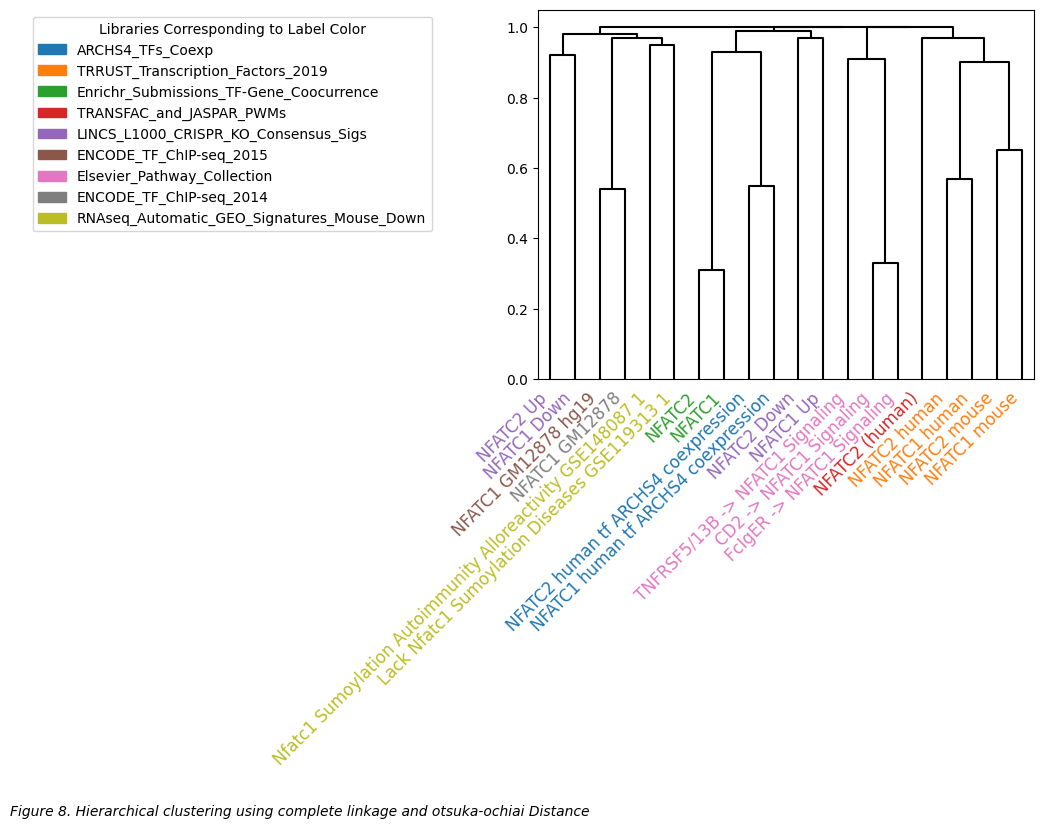

In [43]:
os.makedirs("dendrograms", exist_ok = True)
if otoc:
    distance = lambda x: 1- x.astype(float)
    otoc_distance_matrix = otoc_df.apply(distance)
    otoc_cluster= generate_dendrogram(otoc_distance_matrix, df, linkage_choice, library_color_map, f"Figure 8. Hierarchical clustering using {linkage_choice} linkage and otsuka-ochiai Distance")
    plt.savefig('dendrograms/Otsuka_Ochiai_Dendrogram.png', bbox_inches=  'tight')
    plt.savefig('dendrograms/Otsuka_Ochiai_Dendrogram.svg', bbox_inches = 'tight')
    plt.savefig('dendrograms/Otsuka_Ochiai_Dendrogram.pdf',  bbox_inches = 'tight')


In [44]:
if otoc:
    display(FileLink(f'dendrograms/Otsuka_Ochiai_Dendrogram.png', result_html_prefix = str(f'Download Figure 8. (PNG)           ')))
    display(FileLink(f'dendrograms/Otsuka_Ochiai_Dendrogram.svg', result_html_prefix = str(f'Download Figure 8. (SVG)           ')))
    display(FileLink(f'dendrograms/Otsuka_Ochiai_Dendrogram.pdf', result_html_prefix = str(f'Download Figure 8. (PDF)           ')))

c:\Users\groga\OneDrive\Desktop\MtSinai\appyter-catalog\appyters\GeneSetLibrarySynopsis\dendrograms\Otsuka_Ochiai_Dendrogram.png

c:\Users\groga\OneDrive\Desktop\MtSinai\appyter-catalog\appyters\GeneSetLibrarySynopsis\dendrograms\Otsuka_Ochiai_Dendrogram.svg

c:\Users\groga\OneDrive\Desktop\MtSinai\appyter-catalog\appyters\GeneSetLibrarySynopsis\dendrograms\Otsuka_Ochiai_Dendrogram.pdf

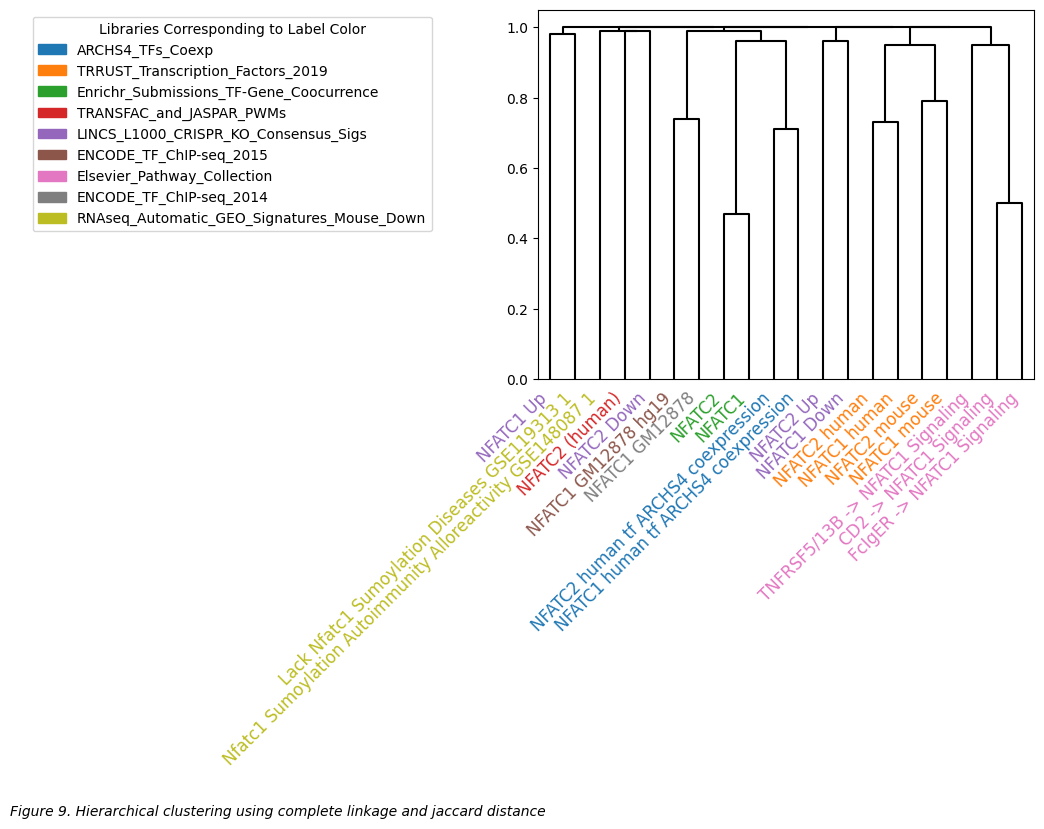

In [45]:
if jaccard:
    jaccard_distance = jac_df.apply(distance)
    jac_cluster = generate_dendrogram(jaccard_distance, df, linkage_choice, library_color_map, f"Figure 9. Hierarchical clustering using {linkage_choice} linkage and jaccard distance")
    plt.savefig('dendrograms/Jaccard_Dendrogram.png', bbox_inches=  'tight')
    plt.savefig('dendrograms/Jaccard_Dendrogram.svg', bbox_inches = 'tight')
    plt.savefig('dendrograms/Jaccard_Dendrogram.pdf',  bbox_inches = 'tight')

In [46]:
if jaccard:
    display(FileLink(f'dendrograms/Jaccard_Dendrogram.png', result_html_prefix = str(f'Download Figure 9. (PNG)           ')))
    display(FileLink(f'dendrograms/Jaccard_Dendrogram.svg', result_html_prefix = str(f'Download Figure 9. (SVG)           ')))
    display(FileLink(f'dendrograms/Jaccard_Dendrogram.pdf', result_html_prefix = str(f'Download Figure 9. (PDF)           ')))

c:\Users\groga\OneDrive\Desktop\MtSinai\appyter-catalog\appyters\GeneSetLibrarySynopsis\dendrograms\Jaccard_Dendrogram.png

c:\Users\groga\OneDrive\Desktop\MtSinai\appyter-catalog\appyters\GeneSetLibrarySynopsis\dendrograms\Jaccard_Dendrogram.svg

c:\Users\groga\OneDrive\Desktop\MtSinai\appyter-catalog\appyters\GeneSetLibrarySynopsis\dendrograms\Jaccard_Dendrogram.pdf

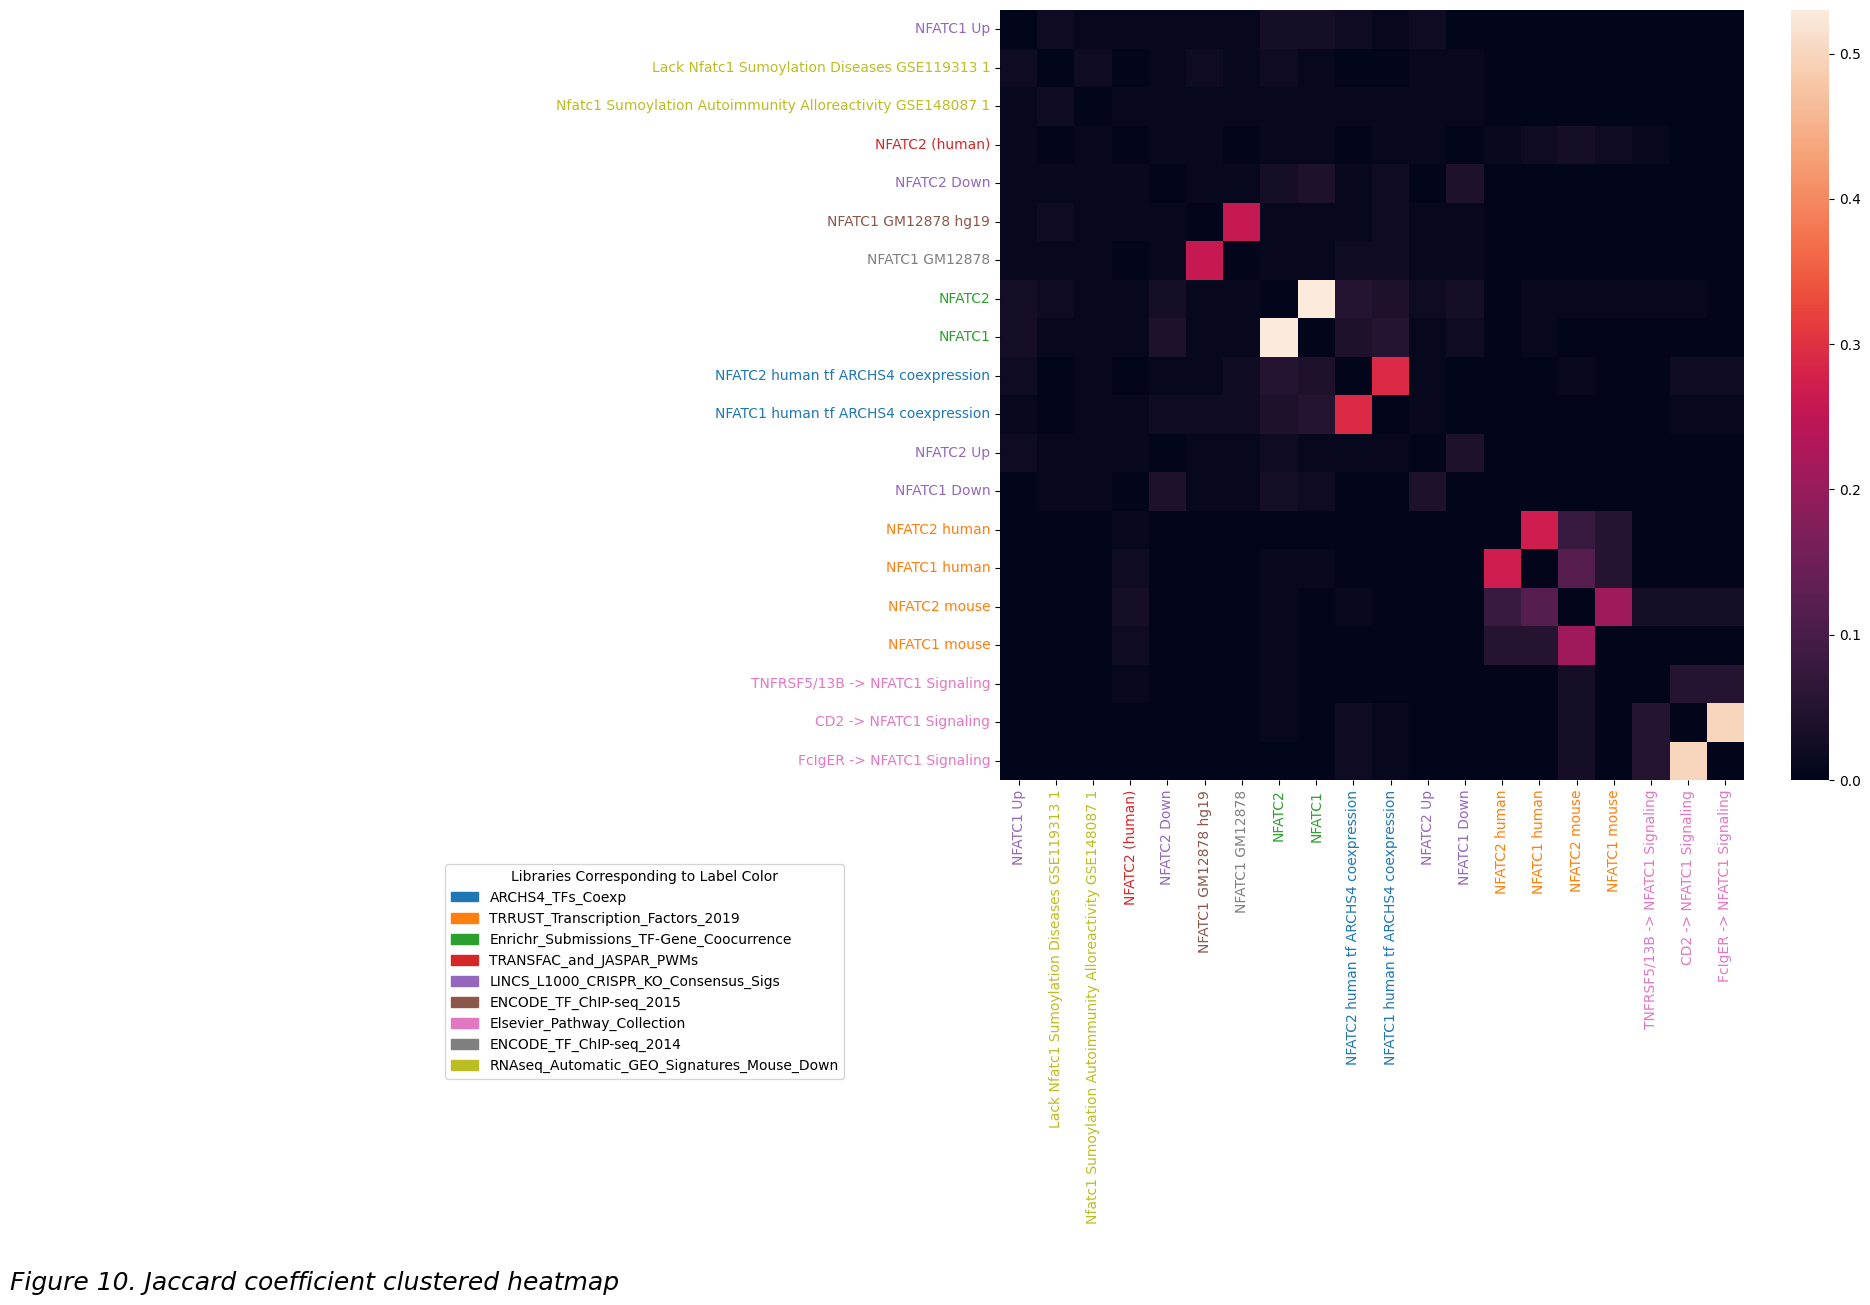

In [47]:
os.makedirs("heatmaps", exist_ok = True)
if jaccard:
    generate_heatmap(jac_cluster, jac_df, df, library_color_map, "Figure 10. Jaccard coefficient clustered heatmap")
    plt.savefig('heatmaps/Jaccard_Heatmap.png', bbox_inches=  'tight')
    plt.savefig('heatmaps/Jaccard_Heatmap.svg', bbox_inches=  'tight')
    plt.savefig('heatmaps/Jaccard_Heatmap.pdf', bbox_inches=  'tight')
    

In [48]:
if jaccard:
    display(FileLink(f'heatmaps/Jaccard_Heatmap.png', result_html_prefix = str(f'Download Figure 10. (PNG)           ')))
    display(FileLink(f'heatmaps/Jaccard_Heatmap.svg', result_html_prefix = str(f'Download Figure 10. (SVG)           ')))
    display(FileLink(f'heatmaps/Jaccard_Heatmap.pdf', result_html_prefix = str(f'Download Figure 10. (PDF)           ')))

c:\Users\groga\OneDrive\Desktop\MtSinai\appyter-catalog\appyters\GeneSetLibrarySynopsis\heatmaps\Jaccard_Heatmap.png

c:\Users\groga\OneDrive\Desktop\MtSinai\appyter-catalog\appyters\GeneSetLibrarySynopsis\heatmaps\Jaccard_Heatmap.svg

c:\Users\groga\OneDrive\Desktop\MtSinai\appyter-catalog\appyters\GeneSetLibrarySynopsis\heatmaps\Jaccard_Heatmap.pdf

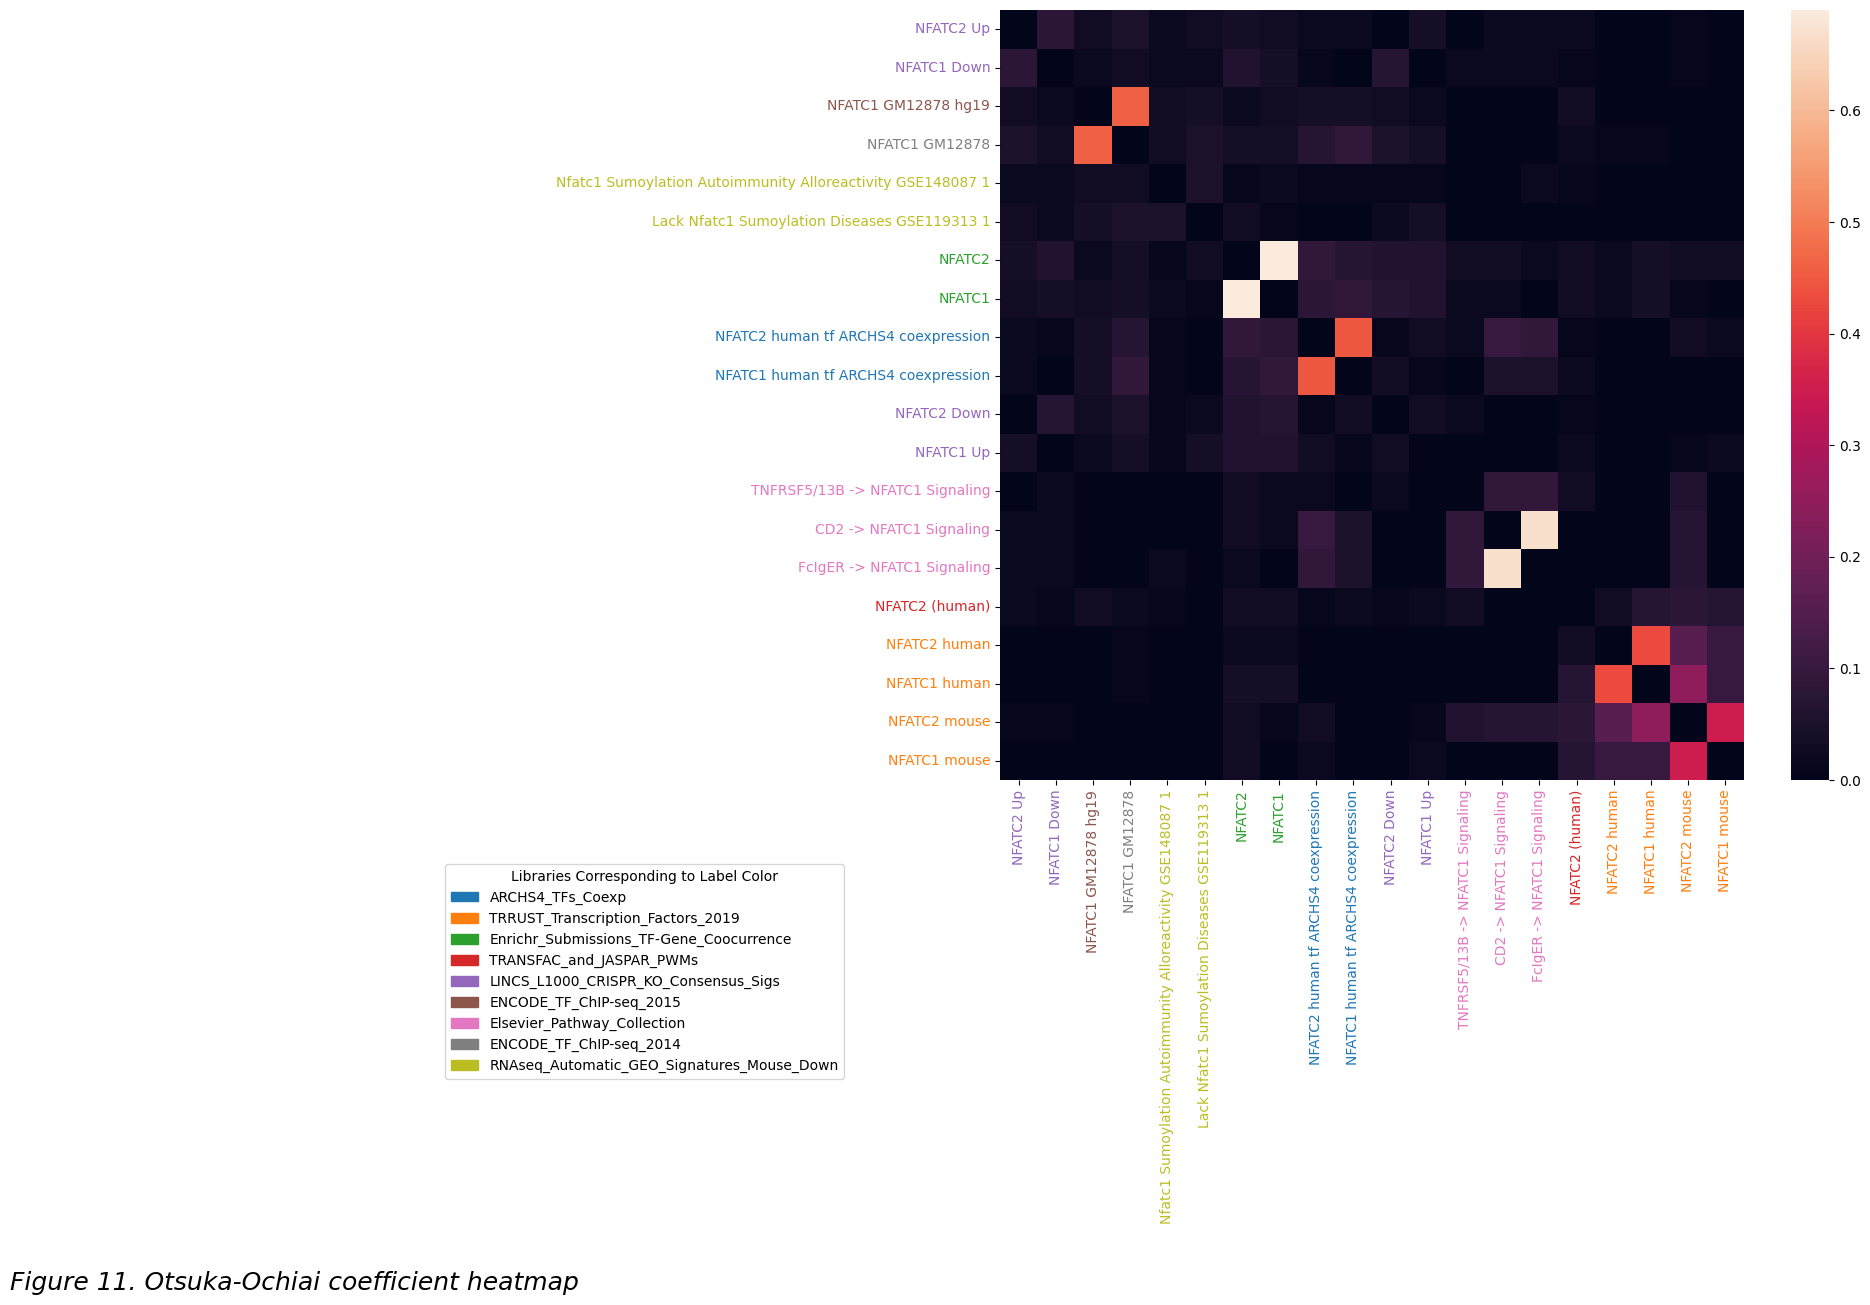

In [49]:
if otoc:
    generate_heatmap(otoc_cluster, otoc_df, df, library_color_map, "Figure 11. Otsuka-Ochiai coefficient heatmap")
    plt.savefig('heatmaps/Otsuka_Ochiai_Heatmap.png', bbox_inches=  'tight')
    plt.savefig('heatmaps/Otsuka_Ochiai_Heatmap.svg', bbox_inches=  'tight')
    plt.savefig('heatmaps/Otsuka_Ochiai_Heatmap.pdf', bbox_inches=  'tight')
    
    

In [50]:
if otoc:
    display(FileLink(f'heatmaps/Otsuka_Ochiai_Heatmap.png', result_html_prefix = str(f'Download Figure 11. (PNG)           ')))
    display(FileLink(f'heatmaps/Otsuka_Ochiai_Heatmap.svg', result_html_prefix = str(f'Download Figure 11. (SVG)           ')))
    display(FileLink(f'heatmaps/Otsuka_Ochiai_Heatmap.pdf', result_html_prefix = str(f'Download Figure 11. (PDF)           ')))

c:\Users\groga\OneDrive\Desktop\MtSinai\appyter-catalog\appyters\GeneSetLibrarySynopsis\heatmaps\Otsuka_Ochiai_Heatmap.png

c:\Users\groga\OneDrive\Desktop\MtSinai\appyter-catalog\appyters\GeneSetLibrarySynopsis\heatmaps\Otsuka_Ochiai_Heatmap.svg

c:\Users\groga\OneDrive\Desktop\MtSinai\appyter-catalog\appyters\GeneSetLibrarySynopsis\heatmaps\Otsuka_Ochiai_Heatmap.pdf